# Plotting Figure S2

This script is used to plot Figure S2 “Grey Swan” regions based on UHWs intensity

ref: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0  

In [1]:
import xarray as xr
import datetime
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import time
import gc
import util
import seaborn as sns
from s3fs.core import S3FileSystem

In [2]:
def draw_screen_poly(lats, lons, map):
    x, y = map( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), 
                   edgecolor="black",
                   facecolor="None",
                   lw=1.5)
    plt.gca().add_patch(poly)

def global_map_plot(df, ax, variable, vmin, vmax, cmap, 
                    cbar_extend="both",
                    lon_labels=[True,False,False,True],
                    lat_labels=[True,False,False,True],
                    reset_lon=False):
    
    if reset_lon!=False:
        # get new coordinate
        df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)
    else:
        df["lon_new"] = df["lon"]
    
    # Midwest US
    # https://en.wikipedia.org/wiki/Module:Location_map/data/USA_Midwest
    lats_mw_us = [ 36.15, 49.5, 49.5, 36.15 ]
    lons_mw_us = [ -95, -95, -75, -75 ]

    # Europe
    lats_eu = [ 40, 50, 50, 40 ]
    lons_eu = [ 15, 15, 30, 30 ]

    # India https://link.springer.com/article/10.1007/s12524-011-0119-x
    # Just say central India and the indo gangetic plains 
    lats_in = [ 18, 25, 25, 18 ]
    lons_in = [ 75, 75, 87, 87 ]

    # https://baike.baidu.com/item/%E5%8D%8E%E5%8C%97%E5%B9%B3%E5%8E%9F
    lats_ch = [ 32, 45, 45, 32 ]
    lons_ch = [ 110, 110, 123, 123 ]    
    
    map = Basemap(ax=ax)
    map.drawcoastlines()
    map.readshapefile('./shapefile/maps', 'maps')
    #map.drawstates()
    #map.drawcountries()
    map.drawmeridians(range(-180, 180, 60),labels=lon_labels,fontsize=12)
    map.drawparallels(range(-60, 70, 30), labels=lat_labels,fontsize=12)
    draw_screen_poly(lats_mw_us, lons_mw_us, map)
    draw_screen_poly(lats_eu, lons_eu, map)
    draw_screen_poly(lats_in, lons_in, map)
    draw_screen_poly(lats_ch, lons_ch, map)
    
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    p = ax.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=0.5, cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)
    
    clb = plt.colorbar(p, ax=ax, orientation="vertical",
                       fraction=0.1,
                       shrink=0.75,
                       pad=0.02,
                       aspect=30,
                       extend=cbar_extend)
    clb.ax.tick_params(labelsize=12)

## load intensity

In [3]:
CMIP={}
CMIP["diff_raw"]={}
CMIP["diff_stat"]={}
CMIP_path="S3://uhws/UHWs_CMIP/"

for year in ["2006","2061"]:
    CMIP[year]={}
    for vari in ["intensity"]: #["frequency","totaldays","intensity","percentile"]:
        CMIP[year][vari]=pd.read_csv(CMIP_path+year+"_"+vari+".csv").set_index(["lat","lon"])
    #CMIP[year]["duration"]=CMIP[year]["totaldays"]/CMIP[year]["frequency"]

for vari in ["intensity"]: #["frequency","totaldays","intensity","duration","percentile"]:
    CMIP["diff_raw"][vari] = CMIP["2061"][vari]-CMIP["2006"][vari]
    CMIP["diff_stat"][vari+"_diff_mean"] = CMIP["diff_raw"][vari].mean(axis=1)
    CMIP["diff_stat"][vari+"_diff_std"] = CMIP["diff_raw"][vari].std(axis=1)
    #CMIP["diff_stat"][vari+"_diff_0.025"] = CMIP["diff_raw"][vari].quantile(0.025,axis=1)
    CMIP["diff_stat"][vari+"_diff_SNR"] = CMIP["diff_stat"][vari+"_diff_mean"].abs()/CMIP["diff_stat"][vari+"_diff_std"]
    
CESM={}
CESM["diff_raw"]={}
CESM["diff_stat"]={}
CESM_path="S3://uhws/UHWs_CESM/"

for year in ["2006","2061"]:
    CESM[year]={}
    for vari in ["intensity"]: #["frequency","totaldays","intensity","percentile"]:
        CESM[year][vari]=pd.read_csv(CESM_path+year+"_"+vari+".csv").set_index(["lat","lon"])
    #CESM[year]["duration"]=CESM[year]["totaldays"]/CESM[year]["frequency"]

for vari in ["intensity"]: #["frequency","totaldays","intensity","duration","percentile"]:
    CESM["diff_raw"][vari] = CESM["2061"][vari]-CESM["2006"][vari]
    CESM["diff_stat"][vari+"_diff_mean"] = CESM["diff_raw"][vari].mean(axis=1)
    CESM["diff_stat"][vari+"_diff_std"] = CESM["diff_raw"][vari].std(axis=1)
    #CESM["diff_stat"][vari+"_diff_0.025"] = CESM["diff_raw"][vari].quantile(0.025,axis=1)
    CESM["diff_stat"][vari+"_diff_SNR"] = CESM["diff_stat"][vari+"_diff_mean"].abs()/CESM["diff_stat"][vari+"_diff_std"]


# merge CMIP with CESM member 002
merge_ens={}

for vari in ["intensity"]:
    merge_ens[vari]=pd.concat([CMIP["diff_raw"][vari].reset_index(),
                    CESM["diff_raw"][vari]["002_max"].reset_index()["002_max"]],
                    axis=1).set_index(["lat","lon"])
    merge_ens[vari+"_diff_mean"]=merge_ens[vari].mean(axis=1)
    merge_ens[vari+"_diff_std"]=merge_ens[vari].std(axis=1)
    merge_ens[vari+"_diff_SNR"]=merge_ens[vari+"_diff_mean"].abs()\
                                /merge_ens[vari+"_diff_std"]
    
merge_ens["intensity_diff_mean"].describe()

count    4439.000000
mean        1.271738
std         0.460092
min        -0.291855
25%         0.937628
50%         1.220316
75%         1.561726
max         3.272609
dtype: float64

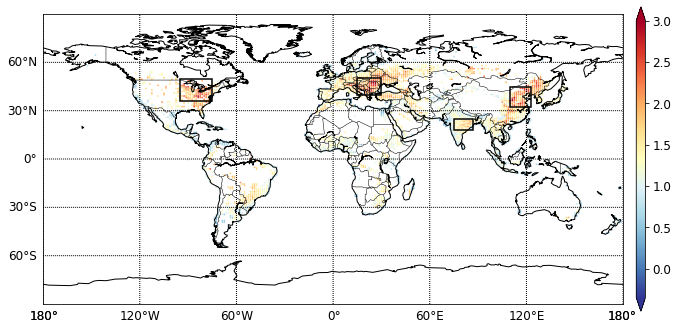

In [4]:
rc={'axes.labelsize': 12, 'font.size': 12, 'legend.fontsize': 12, 'axes.titlesize': 12}
plt.rcParams.update(**rc)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
# ax.set_title("(a)")
global_map_plot(merge_ens["intensity_diff_mean"].reset_index(), 
                ax,
                0, -0.35, 3, "RdYlBu_r", reset_lon=True)
plt.tight_layout()
plt.savefig("../figures/location.pdf",dpi=288)
plt.show()